### Guided Project: Popular Data Science Questions

- What kind of questions are welcomed on the site?  Questions relevant to the topic are welcome on the site.   They should be technical in nature and not "fluff" type questions.   They are geared to solving specific issues people active in that space are experiencing.
- What, other questions, does the site's home subdivide into?   In the Data Science site division is achieved in the Tags section where questions are labeled under tags such as Machine Learning, Python, Neural-Network, etc.

#### Finding Popular Content Using the Query Editor
The Posts table looks to be a good candiate for finding the most popular content.  There are columns for score, view count, answer count, comment count, and favorite count which all look to point to content which has performed better on the website.

https://data.stackexchange.com/datascience/query/new is the link to the query explorer for the Data Science site. The data set will come from there and contain the following columns from the Posts table. Id,
PostTypeId,
CreationDate,
Score,
ViewCount,
Tags,
AnswerCount,
FavoriteCount.

In [ ]:
# read csv file into a dataframe
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ds = pd.read_csv("2019_questions.csv", parse_dates=True)
ds.head()

#### How many missing values are there per column?

FavoriteCount is the only column with missing values which makes sense as many repsonses may not be favored by a user.

In [ ]:
ds.info() 

#### Can we fix the missing values somehow?

In addition to the 7432 null values there are 175 0 values.  Null and zero make up the dominant majority of data in the column.  It does not make sense to fill these with the mean as that would be a likely overstatement.  The best thing to do is for us to enter in zeroes for the null values.  Additionally, I will change this to an integer since a float is not necessary.  

In [ ]:
print(ds["FavoriteCount"].value_counts(dropna=False))
ds["FavoriteCount"] = ds["FavoriteCount"].fillna(0).astype(int)
ds["FavoriteCount"].value_counts(dropna=False)

#### What can be done to change CreationDate to a datetime object?
I will import the datetime library and cleanse that column to convert it into a datetime format.

In [ ]:
ds["CreationDate"] = ds["CreationDate"].apply(pd.to_datetime)
ds.info()

#### What can be done about the Tags column?
We can see below that tags are always a string.

In [ ]:
ds["Tags"].apply(lambda value: type(value)).unique()

#### Create a regular expression that will split the strings apart, remove the unnecessary characters, and maintain the string format so we can look at each string individually.

-     ^ indicates start of a string
-     a|b indicates value can either be or a or b (which will be replaced)
-     $ indicates end of string

str.split then splits the tags apart while maintaining its string attributes.


In [ ]:
ds["Tags"] = ds["Tags"].str.replace("^<|>$", "").str.split("><")
ds.sample(3)

### Most Used and Most Viewed Tags
We will beging by counting how many times each tag was used.


In [ ]:
tag_count = dict()

for tags in ds["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [ ]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

Let's now sort the dataframe by the top 20 tags.

In [ ]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

Most used tags is an arbitrary assumption to use 20, but we can see a rapid decline in values so it seems logical.  We will now visualize the data. 

In [ ]:
most_used.plot(kind="barh", figsize=(16,8))


Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

We'll use pandas's pandas.DataFrame.iterrows().

In [ ]:
tag_view_count = dict()

for index, row in ds.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

most_viewed.plot(kind="barh", figsize=(16,8))

Let's see the two plots side by side.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

In [ ]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

### Relations Between Tags¶
One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [ ]:
all_tags = list(tag_count.index)

We'll now create a dataframe where each row will represent a tag, and each column as well. Something like this:

In [ ]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4,0:4]

We will now fill this dataframe with zeroes and then, for each lists of tags in questions["Tags"], we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used together.

In [ ]:
associations.fillna(0, inplace=True)

for tags in ds["Tags"]:
    associations.loc[tags, tags] += 1


This dataframe is quite large. Let's focus our attention on the most used tags. We'll add some colors to make it easier to talk about the dataframe.

In [104]:
associations.head()

,bert,google-prediction-api,anonymization,management,data-formats,smotenc,lda-classifier,statsmodels,question-answering,ndcg,...,tableau,feature-scaling,multi-instance-learning,nl2sql,supervised-learning,sports,parameter,openai-gym,autoencoder,predict
bert,128,0,0,0,0,0,0,0,4,0,...,0,0,0,2,0,0,0,0,0,0
google-prediction-api,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anonymization,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
management,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
data-formats,0,0,0,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,448,6,6,42,14,24,16,8,10,14,8,8,36,18,42,34,20,38,74,278
statistics,6,468,6,32,32,34,32,6,2,44,2,6,12,0,38,6,22,24,70,178
clustering,6,6,514,0,32,10,4,10,6,40,0,18,48,0,24,0,16,4,90,122
predictive-modeling,42,32,0,530,26,14,56,8,26,62,12,2,24,12,54,22,26,64,70,246
r,14,32,32,26,536,12,20,4,6,44,4,8,2,2,20,20,18,10,48,126
dataset,24,34,10,14,12,680,12,28,14,12,22,22,18,18,56,26,40,64,106,198
regression,16,32,4,56,20,12,694,12,22,48,12,4,74,18,68,62,84,42,118,238
pandas,8,6,10,8,4,28,12,708,14,38,2,6,74,6,6,6,2,2,488,124
lstm,10,2,6,26,6,14,22,14,804,174,48,38,4,86,40,266,138,206,122,142
time-series,14,44,40,62,44,12,48,38,174,932,16,0,24,18,50,102,66,88,210,262



The cells highlighted in yellow tell us that time-series was used together with r 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.
It's hard for a human to understand what is going on in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors will be too skewed.

In [106]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

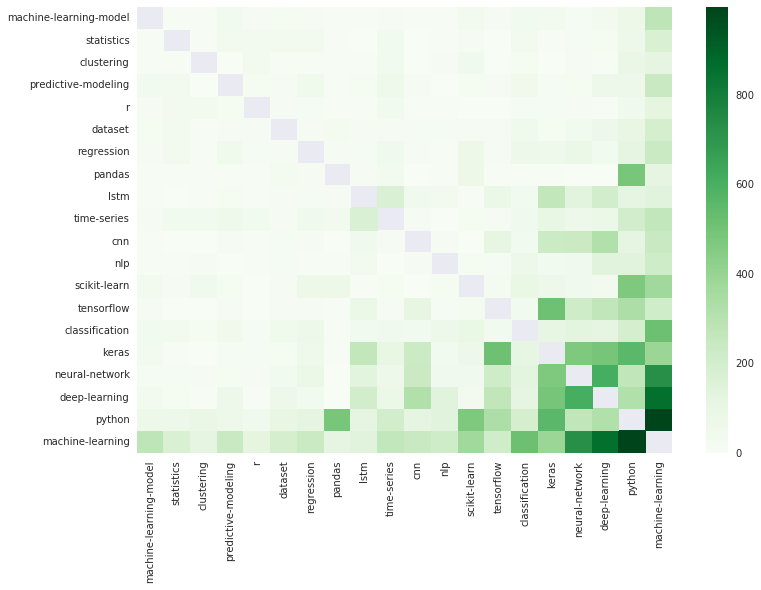

In [107]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, a lot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chances of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, dataset and scikit-learn have a "strong" relation to pandas, but each by itself doesn't.
So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: association rules. Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are (toilet paper and bread are probably more independent than eggs and milk — you'll learn more about statistical independence) in the next step).

We won't get into the details of it, as the technique is out of scope for this course, but it is a path worth investigating!